# Convolutional Neural Network (CNN)

## Data Preprocessing
I will use the function "extract_mel_spectrogram" created in the first notebook to get the features and targets. Before constructing the model though, a few additional steps have to be taken:
1. Values of the mel spectrograms should be scaled so that they are between 0 and 1 for computational efficiency.
2. The data is currently 1000 rows of mel spectrograms that are 128 x 660. We need to reshape this to be 1000 rows of 128 x 660 x 1 to represent that there is a single color channel. If our image had three color channels, RGB, we would need this additional dimension to be 3. 
3. Target values have to be one-hot-encoded in order to be fed into a neural network.

In [2]:
# Imports
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
print("backend: ", keras.backend.backend())
import librosa
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape, LSTM, BatchNormalization
from keras import utils
from keras.utils import to_categorical
import tensorflow as tf

backend:  torch


In [3]:
Fs         = 12000
N_FFT      = 512
N_MELS     = 96
N_OVERLAP  = 256
DURA       = 29.12

In [4]:
def extract_mel_spectrogram(directory):
    '''
    This function takes in a directory of audio files in .wav format, computes the
    mel spectrogram for each audio file, reshapes them so that they are all the 
    same size, and stores them in a numpy array. 
    
    It also creates a list of genre labels and maps them to numeric values.
    
    Parameters:
    directory (int): a directory of audio files in .wav format
    
    Returns:
    X (array): array of mel spectrogram data from all audio files in the given
    directory
    y (array): array of the corresponding genre labels in numeric form
    '''
    
    # Creating empty lists for mel spectrograms and labels
    labels = []
    mel_specs = []
    
    
    # Looping through each file in the directory
    for entry in os.scandir(directory):
        if entry.is_dir():  
            for file in os.scandir(entry):
                # Loading in the audio file
                y, sr = librosa.core.load(file)
                
                # Extracting the label and adding it to the list
                label = str(file).split('.')[0][11:]
                labels.append(label)
                
                # Computing the mel spectrograms
                spect = librosa.feature.melspectrogram(y=y, sr=Fs, n_fft=N_FFT, hop_length=N_OVERLAP, n_mels=N_MELS)
                spect = librosa.power_to_db(spect, ref=np.max)
                
                # Adjusting the size to be 96*2400
                if spect.shape[1] != 2400:
                    spect.resize(96,2400, refcheck=False)
                    
                # Adding the mel spectrogram to the list
                mel_specs.append(spect)
        elif entry.is_file():  
            print(f'- {entry.name}')
        else:  
            print(f'{entry.name}?')
        
    # Converting the list or arrays to an array
    X = np.array(mel_specs)
    
    # Converting labels to numeric values
    labels = pd.Series(labels)
    label_dict = {
        'jazz': 0,
        'reggae': 1,
        'rock': 2,
        'blues': 3,
        'hiphop': 4,
        'country': 5,
        'metal': 6,
        'classical': 7,
        'disco': 8,
        'pop': 9
    }
    y = labels.map(label_dict).values
    
    # Returning the mel spectrograms and labels
    return X, y

In [5]:
# Using the function to read and extract mel spectrograms from the GTZAN Genre Dataset audio files
path = os.path.join(os.path.pardir, 'Data', 'genres', 'audiofiles')

X, y = extract_mel_spectrogram(path)

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.2)

**Note:** It is important that we train test split before scaling and reshaping the data to avoid data leakage.

In [7]:
# Checking the minimum value (the scale ranges from zero to some negative value) to see how we should scale the data
X_train.min()

-80.0

In [8]:
# Scaling our data to be between 0 and 1 using the minimum value from above
X_train /= -80
X_test /= -80

In [9]:
# Reshaping images to be 128 x 660 x 1, where the 1 represents the single color channel
X_train = X_train.reshape(X_train.shape[0], 96, 2400, 1)
X_test = X_test.reshape(X_test.shape[0], 96, 2400, 1)

In [10]:
# One hot encoding our labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Constructing a Feed Forward Neural Network (FFNN)
Before running a CNN, I wanted to train a feed forward neural network (FFNN) for comparison. CNNs have additional layers for edge detection that make them well suited for image classification problems, but they tend to be more computationally expensive than FFNNs. If a FFNN could perform just as well, there would be no need to use a CNN.

In [16]:
# Initializing a random seed for replication purposes
np.random.seed(42)

# Initiating an empty neural network
model = keras.Sequential()

# Adding a flattened layer to input our image data
model.add(Flatten(input_shape = (96, 2400, 1)))

# Adding a dense layer with 128 neurons
model.add(Dense(128, activation='relu'))

# Adding a dense layer with 128 neurons
model.add(Dense(128, activation='relu'))

# Adding a dense layer with 64 neurons
model.add(Dense(64, activation='relu'))

# Adding an output layer
model.add(Dense(10, activation='softmax'))

# Compiling our neural network
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fitting our neural network
history = model.fit(X_train,
                    y_train, 
                    batch_size=16,
                    validation_data=(X_test, y_test),
                    epochs=40)

Epoch 1/40


C:\Users\wen\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1032 - loss: 13.4928 - val_accuracy: 0.1000 - val_loss: 14.5063
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1013 - loss: 14.4852 - val_accuracy: 0.1000 - val_loss: 14.5063
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.0823 - loss: 14.7923 - val_accuracy: 0.1000 - val_loss: 14.5063
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1026 - loss: 14.4652 - val_accuracy: 0.1000 - val_loss: 14.5063
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1238 - loss: 14.1222 - val_accuracy: 0.1000 - val_loss: 14.5063
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1013 - loss: 14.4849 - val_accuracy: 0.1000 - val_loss: 14.5063
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0989 - loss: 14.5235 - val_accuracy: 0.1000 - val_loss: 14.5063
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1023 - loss: 14.4692 - val_accuracy: 0.1000

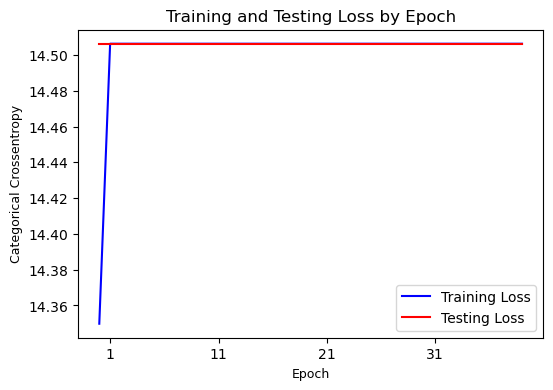

In [17]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(6, 4))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 12)
plt.xlabel('Epoch', fontsize = 9)
plt.ylabel('Categorical Crossentropy', fontsize = 9)
plt.xticks(range(1, len(train_loss)+1, 10))

plt.legend(fontsize = 10);

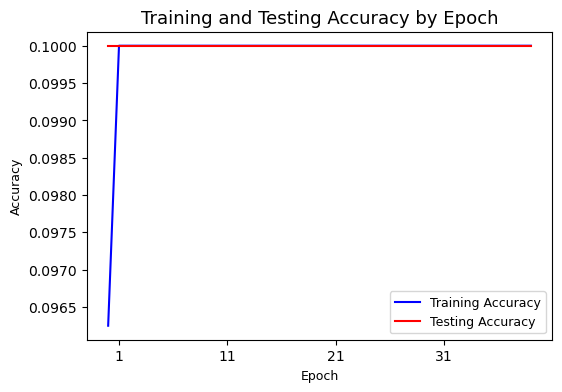

In [18]:
# Check out our train accuracy and test accuracy over epochs.
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(6, 4))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 13)
plt.xlabel('Epoch', fontsize = 9)
plt.ylabel('Accuracy', fontsize = 9)
plt.xticks(range(1, len(train_loss)+1, 10))

plt.legend(fontsize = 9);

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.10000000149011612


**Note:** After trying several different architectures, the best model (based on test accuracy) achieved a training score of 69% and a test score of 45%.

## Constructing a CNN

In [20]:
# Initializing a random seed for replication purposes
np.random.seed(42)
tf.random.set_seed(42)

# Initiating an empty neural network
cnn_model = keras.Sequential(name='cnn_1')

# Adding convolutional layer
cnn_model.add(Conv2D(filters=16,
                     kernel_size=(4,4),
                     activation='relu',
                     input_shape=(96, 2400, 1)))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional layer
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(4,4),
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))


#Adding convolutionale layer
cnn_model.add(Conv2D(filters=16,
                     kernel_size=(4,4),
                     activation='relu'))
                     
# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding convolutional layer
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(4,4),
                     activation='relu'))

# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten())

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64, activation='relu'))

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.25))

# Adding an output layer
cnn_model.add(Dense(10, activation='softmax'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
# Checking the model summary
cnn_model.summary()

Model: "cnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 93, 2397, 16)   │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 46, 599, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 43, 596, 32)    │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 21, 149, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 146, 16)    │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 9, 36, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 33, 32)      │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,794 (292.16 KB)

 Trainable params: 74,794 (292.16 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:

# Fitting our neural network
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=100)

Epoch 1/100
 4/50 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.0495 - loss: 2.3144

C:\Users\wen\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\torch\nn.py:416: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  outputs = tnn.conv2d(


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.0924 - loss: 2.3061 - val_accuracy: 0.1000 - val_loss: 2.3003
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.0973 - loss: 2.3044 - val_accuracy: 0.1100 - val_loss: 2.2886
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.1550 - loss: 2.2873 - val_accuracy: 0.1600 - val_loss: 2.2414
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.1954 - loss: 2.2225 - val_accuracy: 0.1550 - val_loss: 2.1960
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.1514 - loss: 2.2014 - val_accuracy: 0.1850 - val_loss: 2.0796
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.1923 - loss: 2.1008 - val_accuracy: 0.2750 - val_loss: 2.0580
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.2424 - loss: 2.0319 - val_accuracy: 0.2600 - val_loss: 2.0149
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.2836 - loss: 2.0141 - val_accuracy: 0.3150 - val_l

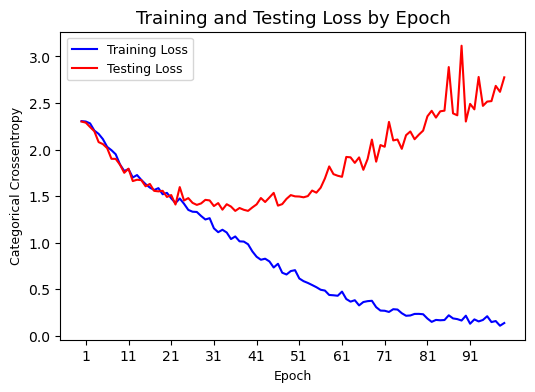

In [23]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(6, 4))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 13)
plt.xlabel('Epoch', fontsize = 9)
plt.ylabel('Categorical Crossentropy', fontsize = 9)
plt.xticks(range(1, len(train_loss)+1, 10))

plt.legend(fontsize = 9);

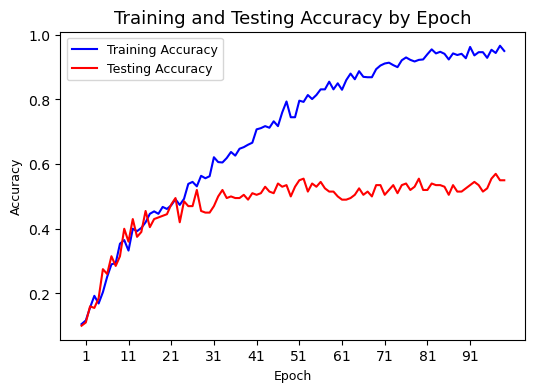

In [24]:
# Check out our train accuracy and test accuracy over epochs.
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(6, 4))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 13)
plt.xlabel('Epoch', fontsize = 9)
plt.ylabel('Accuracy', fontsize = 9)
plt.xticks(range(1, len(train_loss)+1, 10))

plt.legend(fontsize = 9);

In [25]:
score = cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.550000011920929


## CRNN

In [11]:
# Initializing a random seed for replication purposes
np.random.seed(42)
tf.random.set_seed(42)

# Initiating an empty neural network
crnn_model = keras.Sequential(name='cnn_1')

# Adding convolutional layer
crnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=(96,2400,1), padding='SAME'))

# Adding max pooling layer
crnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Adding a dropout layer for regularization
crnn_model.add(Dropout(0.2))

# Adding convolutional layer
crnn_model.add(Conv2D(filters=64,
                     kernel_size=(3,3),
                     activation='relu', padding='SAME'))

# Adding max pooling layer
crnn_model.add(MaxPooling2D(pool_size=(3,3)))

# Adding a dropout layer for regularization
crnn_model.add(Dropout(0.2))

# Adding convolutional layer
crnn_model.add(Conv2D(filters=64,
                     kernel_size=(3,3),
                     activation='relu', padding='SAME'))

# Adding max pooling layer
crnn_model.add(MaxPooling2D(pool_size=(4,4)))

crnn_model.add(Dropout(0.2))

# Adding convolutional layer
crnn_model.add(Conv2D(filters=64,
                     kernel_size=(3,3),
                     activation='relu', padding='SAME'))

# Adding max pooling layer
crnn_model.add(MaxPooling2D(pool_size=(4,4)))

crnn_model.add(Dropout(0.2))

# Adding a Reshape layer
crnn_model.add(Reshape((25, -1)))

#Adding a LSTM layer
crnn_model.add(LSTM(20, return_sequences=True))

#Adding a LSTM layer
crnn_model.add(LSTM(20))

# Adding a dense layer with 32 neurons
crnn_model.add(Dense(32, activation='relu'))

# Adding an output layer
crnn_model.add(Dense(10, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# Compiling our neural network
crnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

crnn_model.summary()

C:\Users\wen\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "cnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 2400, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 1200, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 1200, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 1200, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 400, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 400, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 400, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 100, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 100, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 100, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 25, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 25, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 25, 20)         │         6,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,754 (405.29 KB)

 Trainable params: 103,754 (405.29 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:

# Fitting our neural network
history = crnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=100)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.1041 - loss: 2.3061 - val_accuracy: 0.1000 - val_loss: 2.3031
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.1222 - loss: 2.2972 - val_accuracy: 0.1000 - val_loss: 2.3073
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.2016 - loss: 2.2432 - val_accuracy: 0.1000 - val_loss: 2.3362
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.1802 - loss: 2.2313 - val_accuracy: 0.1000 - val_loss: 2.3877
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.2145 - loss: 2.1239 - val_accuracy: 0.1000 - val_loss: 2.3405
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 0.2574 - loss: 2.0276 - val_accuracy: 0.1300 - val_loss: 2.2940
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.2603 - loss: 2.0014 - val_accuracy: 0.1450 - val_loss: 2.3823
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.2761 - loss: 1.8894 - val_acc

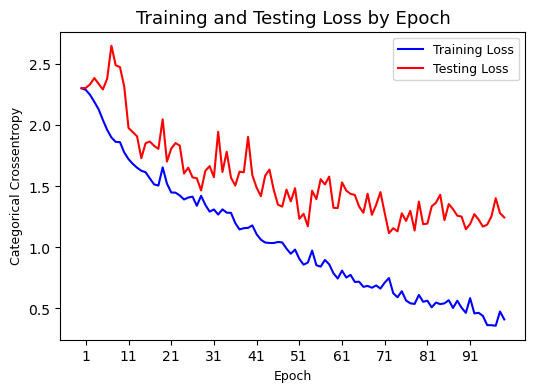

In [13]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(6, 4))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 13)
plt.xlabel('Epoch', fontsize = 9)
plt.ylabel('Categorical Crossentropy', fontsize = 9)
plt.xticks(range(1, len(train_loss)+1, 10))

plt.legend(fontsize = 9);

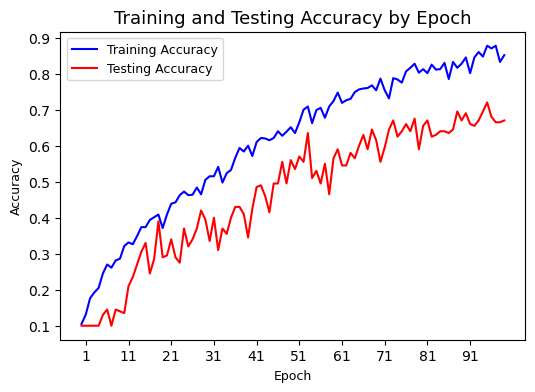

In [14]:
# The code in this cell was adapted from a lecture at General Assembly

# Check out our train accuracy and test accuracy over epochs.
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(6, 4))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 13)
plt.xlabel('Epoch', fontsize = 9)
plt.ylabel('Accuracy', fontsize = 9)
plt.xticks(range(1, len(train_loss)+1, 10))

plt.legend(fontsize = 9);

**Note:** Most of the models I ran became increasingly overfit after about 15-20 epochs, so increasing the number of epochs would likely not improve the model.

In [26]:
FFNN_score = model.evaluate(X_test, y_test, verbose=0)
CNN_score = cnn_model.evaluate(X_test, y_test, verbose=0)
CRNN_score = crnn_model.evaluate(X_test, y_test, verbose=0)
print('FFNN Test accuracy:', FFNN_score[1])
print('CNN Test accuracy:', CNN_score[1])
print('CRNN Test accuracy:', CRNN_score[1])

FFNN Test accuracy: 0.10000000149011612
CNN Test accuracy: 0.550000011920929
CRNN Test accuracy: 0.6700000166893005


In [27]:
import pandas as pd
results = {
    'Model': ['Feedforward Neural Network (FFNN)', 'Convolutional Neural Network (CNN)', 'Convolutional Recurrent Neural Network (CRNN)'],
    'Test Accuracy': [0.10000000149011612, 0.5249999761581421, 0.6700000166893005]
}
df = pd.DataFrame(results)
print(df)

                                           Model  Test Accuracy
0              Feedforward Neural Network (FFNN)          0.100
1             Convolutional Neural Network (CNN)          0.525
2  Convolutional Recurrent Neural Network (CRNN)          0.670


In [22]:
# Making predictions from the cnn model
predictions = cnn_model.predict(X_test, verbose=1)

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


### Confusion Matrix
To look deeper into what was happening with the model, I computed a confusion matrix to visualize the model's predictions against the actual values.

**Note:** since the confusion matrix function from sklearn does not return the labels for predicted values and actual values, I checked how many predicted and actual values there were for each genre to be able to figure it out.

In [28]:
# Checking the number of targets per class
for i in range(10): 
    print(f'{i}: {sum([1 for target in y_test if target[i] == 1])}')

0: 20
1: 20
2: 20
3: 20
4: 20
5: 20
6: 20
7: 20
8: 20
9: 20


In [29]:
# Checking the number of predicted values in each class
for i in range(10): 
    print(f'{i}: {sum([1 for prediction in predictions if np.argmax(prediction) == i])}')

0: 15
1: 12
2: 32
3: 22
4: 37
5: 15
6: 18
7: 12
8: 16
9: 21


In [30]:
# Calculating the confusion matrix 
# row: actual
# columns: predicted
conf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions, 1))
conf_matrix

array([[ 9,  0,  1,  3,  2,  3,  0,  1,  0,  1],
       [ 1,  8,  1,  1,  8,  0,  0,  0,  1,  0],
       [ 0,  0, 12,  2,  0,  1,  2,  1,  1,  1],
       [ 1,  1,  2, 12,  1,  1,  0,  0,  1,  1],
       [ 0,  0,  1,  0, 17,  0,  1,  0,  0,  1],
       [ 1,  1,  5,  3,  0,  7,  1,  0,  1,  1],
       [ 0,  0,  2,  0,  3,  0, 14,  0,  0,  1],
       [ 3,  0,  4,  1,  0,  1,  0, 10,  0,  1],
       [ 0,  2,  2,  0,  3,  2,  0,  0,  9,  2],
       [ 0,  0,  2,  0,  3,  0,  0,  0,  3, 12]], dtype=int64)

In [31]:
# Creating a dataframe of the confusion matrix with labels for readability 
confusion_df = pd.DataFrame(conf_matrix)
confusion_df

,0,1,2,3,4,5,6,7,8,9
0,9,0,1,3,2,3,0,1,0,1
1,1,8,1,1,8,0,0,0,1,0
2,0,0,12,2,0,1,2,1,1,1
3,1,1,2,12,1,1,0,0,1,1
4,0,0,1,0,17,0,1,0,0,1
5,1,1,5,3,0,7,1,0,1,1
6,0,0,2,0,3,0,14,0,0,1
7,3,0,4,1,0,1,0,10,0,1
8,0,2,2,0,3,2,0,0,9,2
9,0,0,2,0,3,0,0,0,3,12


In [32]:
# Creating a dictionary of labels
labels_dict = {
    0: 'jazz',
    1: 'reggae',
    2: 'rock',
    3: 'blues',
    4: 'hiphop',
    5: 'country',
    6: 'metal',
    7: 'classical',
    8: 'disco',
    9: 'pop'
}

In [33]:
# Renaming rows and columns with labes
confusion_df = confusion_df.rename(columns=labels_dict)
confusion_df.index = confusion_df.columns
confusion_df

,jazz,reggae,rock,blues,hiphop,country,metal,classical,disco,pop
jazz,9,0,1,3,2,3,0,1,0,1
reggae,1,8,1,1,8,0,0,0,1,0
rock,0,0,12,2,0,1,2,1,1,1
blues,1,1,2,12,1,1,0,0,1,1
hiphop,0,0,1,0,17,0,1,0,0,1
country,1,1,5,3,0,7,1,0,1,1
metal,0,0,2,0,3,0,14,0,0,1
classical,3,0,4,1,0,1,0,10,0,1
disco,0,2,2,0,3,2,0,0,9,2
pop,0,0,2,0,3,0,0,0,3,12


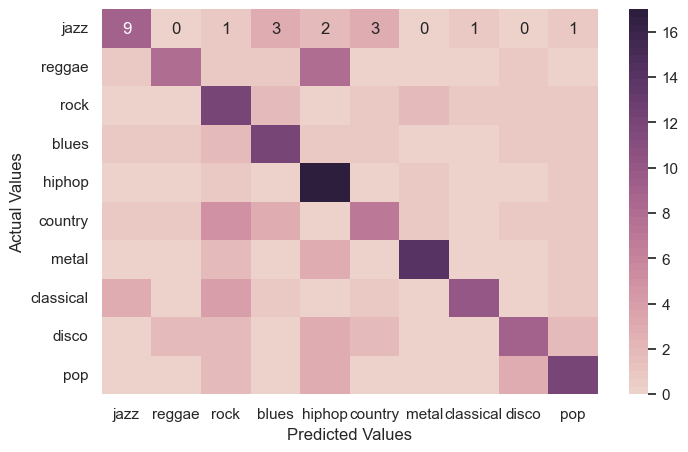

In [34]:
# Creating a heatmap for the confusion matrix for display
plt.figure(figsize= (8,5))
sns.set(font_scale = 1)
ax = sns.heatmap(confusion_df, annot=True , cmap=sns.cubehelix_palette(50))
ax.set(xlabel='Predicted Values', ylabel='Actual Values')
plt.show()